In [ ]:
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py

import gc
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split
from vocab import Vocab

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from tqdm import tqdm, trange

%matplotlib inline

--2025-03-19 22:41:41--  https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2879 (2.8K) [text/plain]
Saving to: ‘vocab.py’

vocab.py            100%[===================>]   2.81K  --.-KB/s    in 0s      

2025-03-19 22:41:41 (39.3 MB/s) - ‘vocab.py’ saved [2879/2879]



In [ ]:
import os

if os.path.exists('data.txt'):
    print('Data already downloaded')
else:
    !wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt

--2025-03-19 22:42:00--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1 [following]
--2025-03-19 22:42:01--  https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc449965dfac9c5375195317ab09.dl.dropboxusercontent.com/cd/0/inline/CmN_U5vYpbdaYLzSLoQtNG2xL2FBgHDtMekA8aJu6FvOy5cTQl9FGa9UZHsnR0VWPyzdLchgNrAz5jmQfeHfxUrIIQ_7Slnmvb7IRuh3PETqmpu68CwKDMsHYtKWkHfbXp8/file?dl=1# [following]
--2025-03-19 22:42:01--  https://uc449965dfac9c5375195317ab09.dl.dropboxusercontent.com/cd/0/inline/CmN_U5vYpbd

# Новый раздел

In [ ]:
with open('data.txt') as f:
  assert f.readlines()[0] == 'Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.\n'

In [ ]:
!pip install subword_nmt
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [ ]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
  return ' '.join(tokenizer.tokenize(x.lower()))

with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
  for line in open('data.txt'):
    src_line, dst_line = line.strip().split('\t')
    f_src.write(tokenize(src_line) + '\n')
    f_dst.write(tokenize(dst_line) + '\n')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        # enc_seq: [batch, sequence length, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state) # input & hidden states
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units

        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        batch_size, ninp, enc_size = enc.shape

        # Compute logits
        x = self.linear_dec(dec).reshape(-1, 1, self.hid_size)
        x = torch.tanh(self.linear_enc(enc) + x)
        x = self.linear_out(x)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        x[torch.where(inp_mask == False)] = -1e9

        # Compute attention probabilities (softmax)
        probs = self.softmax(x.reshape(batch_size, ninp))

        # Compute attention response using enc and probs
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(1)

        return attn, probs

In [ ]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)

        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes input sequences, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        #[dec_start] = super().encode(inp, **flags)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        dec_start = self.dec_start(last_state)

        # apply attention layer from initial decoder hidden state
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor

        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]

In [ ]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return -logp_out[mask].mean()

In [ ]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

In [ ]:
from typing import NamedTuple

class Config(NamedTuple):
    num_symbols: int = 8_000 # BPE vocabulary size

    test_size: int = 3_000 # train/dev split
    random_state: int = 2023

class TrainConfig(NamedTuple):
    batch_size: int = 128
    num_epochs: int = 10
    lr: float = 1e-3

class Trainer:
    @staticmethod
    def train_bpe(num_symbols: int) -> None:
        bpe: dict[str, BPE] = {}
        for lang in ['en', 'ru']:
            learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=num_symbols)
            bpe[lang] = BPE(open('./bpe_rules.' + lang))

            with open('train.bpe.' + lang, 'w') as f_out:
                for line in open('train.' + lang):
                    f_out.write(bpe[lang].process_line(line.strip()) + '\n')
        return bpe

    @staticmethod
    def get_data(test_size: int = 3_000, random_state: int = 2023) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
        data_out = np.array(open('./train.bpe.en').read().split('\n'))

        train_inp, dev_inp, train_out, dev_out = train_test_split(
            data_inp,
            data_out,
            test_size=test_size,
            random_state=random_state,
        )
        return train_inp, dev_inp, train_out, dev_out

    def __init__(self, config: Config):
        self.config = config

        self.train_bpe(self.config.num_symbols)

        self.train_inp, self.dev_inp, self.train_out, self.dev_out = self.get_data(self.config.test_size, self.config.random_state)

        self.inp_voc = Vocab.from_lines(self.train_inp)
        self.out_voc = Vocab.from_lines(self.train_out)

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f'used self.device: {self.device}')

    def train(self, model: BasicModel, train_config: TrainConfig):
        metrics = {'train_loss': [], 'dev_bleu': [] }

        opt = torch.optim.Adam(model.parameters(), lr=train_config.lr)
        for _ in range(train_config.num_epochs):
            step = len(metrics['train_loss']) + 1
            batch_ix = np.random.randint(len(self.train_inp), size=train_config.batch_size)
            batch_inp = self.inp_voc.to_matrix(self.train_inp[batch_ix]).to(self.device)
            batch_out = self.out_voc.to_matrix(self.train_out[batch_ix]).to(self.device)

            opt.zero_grad()
            loss_t = compute_loss(model, batch_inp, batch_out)
            loss_t.backward()
            opt.step()

            metrics['train_loss'].append((step, loss_t.item()))

            if step % 100 == 0:
                metrics['dev_bleu'].append((step, compute_bleu(model, self.dev_inp, self.dev_out)))

                clear_output(True)
                plt.figure(figsize=(12,4))
                for i, (name, history) in enumerate(sorted(metrics.items())):
                    plt.subplot(1, len(metrics), i + 1)
                    plt.title(name)
                    plt.plot(*zip(*history))
                    plt.grid()
                plt.show()
                print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)




In [ ]:
initial_trainer = Trainer(Config())

100%|██████████| 8000/8000 [00:13<00:00, 615.17it/s] 


used self.device: cuda


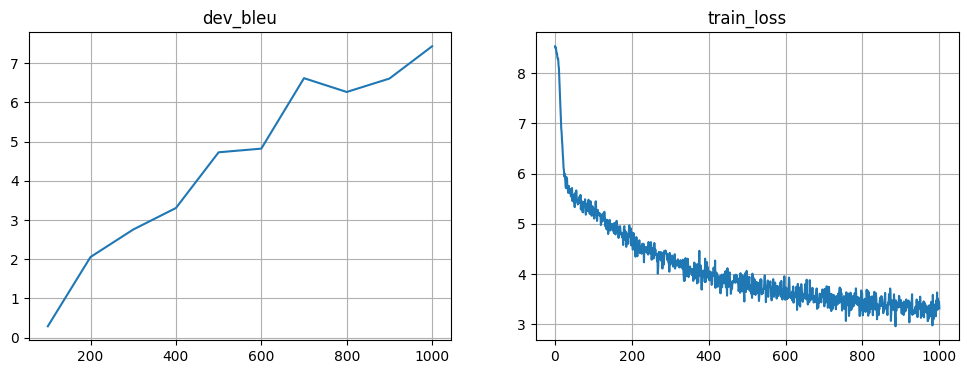

Mean loss=3.399


In [ ]:
model = AttentiveModel(initial_trainer.inp_voc, initial_trainer.out_voc).to(initial_trainer.device)
initial_trainer.train(model, TrainConfig(batch_size=128, num_epochs=1000))
compute_bleu(model, initial_trainer.dev_inp, initial_trainer.dev_out)

torch.cuda.empty_cache()
gc.collect()

## 1. Dataset Size

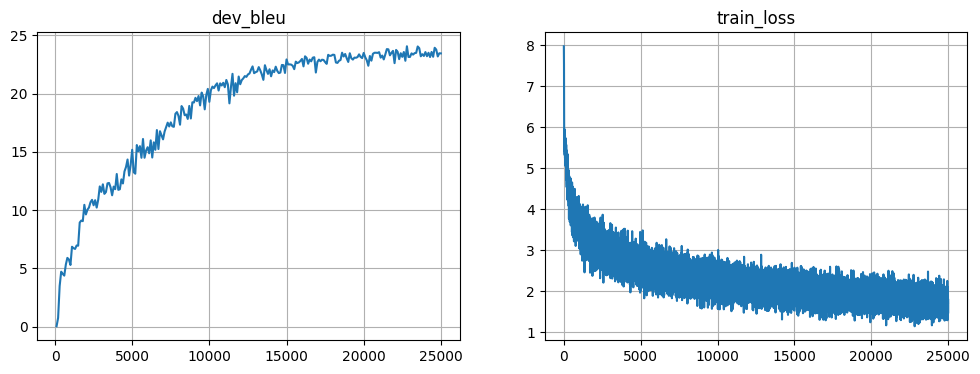

Mean loss=1.635


In [ ]:
trainer = Trainer(Config(num_symbols=4_000))

model = AttentiveModel(trainer.inp_voc, trainer.out_voc).to(trainer.device)
trainer.train(model, TrainConfig(batch_size=32, num_epochs=25_000))
print(f'BLeu: {compute_bleu(model, trainer.dev_inp, trainer.dev_out)}')
torch.cuda.empty_cache()
_ = gc.collect()

In [ ]:
print(f'BLeu: {compute_bleu(model, trainer.dev_inp, trainer.dev_out)}')
for inp_line, trans_line in zip(trainer.dev_inp[::500], model.translate_lines(trainer.dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

BLeu: 23.454246991154655
в ванной комнате с ванной предоставляется фен .
the bathroom comes with a bath and a hairdryer .

на территории можно сыграть в дарт@@ с и ск@@ во@@ ш .
a children ’ s play area is available on site , and football stadium is available on site .

апартаменты располагают гостиной зоной .
the apartment will provide you with a seating area .

гости могут самостоятельно приготовить блюда на полностью укомплекто@@ ванной кухне .
guests can prepare their meals in the fully equipped kitchen .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
the two - bedroom apartment has a private bathroom with a bath and shower , and a bathroom , and a kitchen with a microwave and a microwave .

ужин для гостей пригото@@ вят в ресторане ron@@ ni@@ e ' s w@@ ing@@ s & o@@ y@@ st@@ er ba@@ r .
you can enjoy a meal at the on - site restaurant on the island yo@@ uth of the on - site restaurant .



Было предпопложение, что модели сложно выучить эмбеды на большое количество токенов, уменьшили и получили позитивный результат 

## 2 Different architecture

In [ ]:
class AttentiveModelWithGRU(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.enc0 = nn.GRU(emb_size, hid_size, num_layers=4, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)

        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes input sequences, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        #[dec_start] = super().encode(inp, **flags)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        dec_start = self.dec_start(last_state)

        # apply attention layer from initial decoder hidden state
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor

        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]


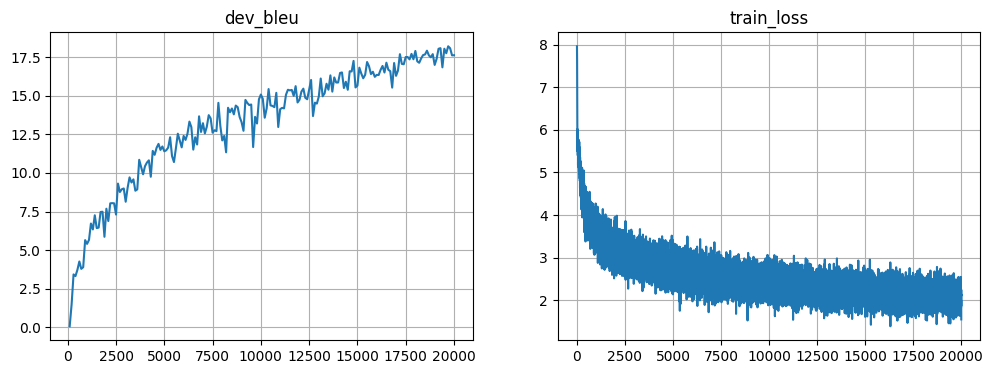

Mean loss=1.945


In [ ]:
trainer = Trainer(Config(num_symbols=4_000))

model = AttentiveModelWithGRU(trainer.inp_voc, trainer.out_voc).to(trainer.device)
trainer.train(model, TrainConfig(batch_size=32, num_epochs=20_000))
torch.cuda.empty_cache()
_ = gc.collect()

In [ ]:
print(f'BLeu: {compute_bleu(model, trainer.dev_inp, trainer.dev_out)}')

BLeu: 17.618001535813818


Оказалось, что усложенеине не дало результатов при одинаковом колличестве эпох, если их будет больше, то должно стать лучше

## 3 LR scheduling

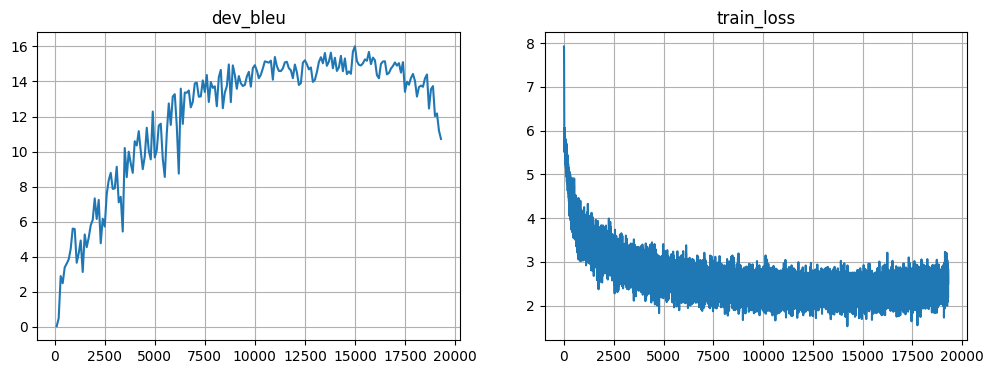

Mean loss=2.603


In [ ]:
class TrainConfigWithScheduler(TrainConfig):
    step_size: int = 1_000
    gamma: float = 1.1

class TrainerWithScheduler(Trainer):
    def __init__(self, config: Config):
        super().__init__(config)

    def train(self, model: BasicModel, train_config: TrainConfig):
        assert isinstance(train_config, TrainConfigWithScheduler)
        metrics = {'train_loss': [], 'dev_bleu': [] }

        opt = torch.optim.Adam(model.parameters(), lr=train_config.lr)
        sch = torch.optim.lr_scheduler.StepLR(opt, step_size=train_config.step_size, gamma=train_config.gamma)
        for _ in range(train_config.num_epochs):
            step = len(metrics['train_loss']) + 1
            batch_ix = np.random.randint(len(self.train_inp), size=train_config.batch_size)
            batch_inp = self.inp_voc.to_matrix(self.train_inp[batch_ix]).to(self.device)
            batch_out = self.out_voc.to_matrix(self.train_out[batch_ix]).to(self.device)

            opt.zero_grad()
            loss_t = compute_loss(model, batch_inp, batch_out)
            loss_t.backward()
            opt.step()
            sch.step()

            metrics['train_loss'].append((step, loss_t.item()))

            if step % 100 == 0:
                metrics['dev_bleu'].append((step, compute_bleu(model, self.dev_inp, self.dev_out)))

                clear_output(True)
                plt.figure(figsize=(12,4))
                for i, (name, history) in enumerate(sorted(metrics.items())):
                    plt.subplot(1, len(metrics), i + 1)
                    plt.title(name)
                    plt.plot(*zip(*history))
                    plt.grid()
                plt.show()
                print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


trainer = TrainerWithScheduler(Config(num_symbols=4_000))

model = AttentiveModelWithGRU(trainer.inp_voc, trainer.out_voc).to(trainer.device)
trainer.train(model, TrainConfigWithScheduler(batch_size=32, num_epochs=25_000))
torch.cuda.empty_cache()
_ = gc.collect()

шедульер ледает хуже, наверное, не так подобраны параметры

In [ ]:
print(f'BLeu: {compute_bleu(model, trainer.dev_inp, trainer.dev_out)}')


## 4 Sampling

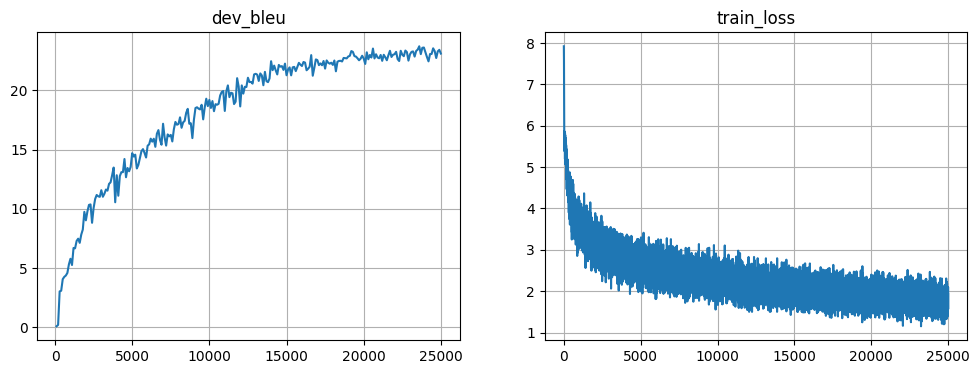

Mean loss=1.820


In [ ]:
class AttentiveModelWithDecodeSampling(AttentiveModelWithGRU):
    temperature: float = 1.0
    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            # outputs.append(logits.argmax(dim=-1))
            probs = F.softmax(logits / self.temperature, dim=-1)
            outputs.append(torch.multinomial(probs, num_samples=1).squeeze(1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

trainer = Trainer(Config(num_symbols=4_000))

model = AttentiveModel(trainer.inp_voc, trainer.out_voc).to(trainer.device)
trainer.train(model, TrainConfig(batch_size=32, num_epochs=25_000))
(f'BLeu: {compute_bleu(model, trainer.dev_inp, trainer.dev_out)}')
torch.cuda.empty_cache()
_ = gc.collect()

семплинг незначительно влияет на обучение, однако, тут появляется доп гипперпараметр - температура семлирования. Возможно, шатая температуру, можнм повысить качество (или уменьшить)   

## 5 Stady

По итогу решили, что лучший вариант -- уменьшее датасета